# Ultrasonic vocalizations from mice

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import librosa.feature
import colorcet as cc
import umap
from scipy.cluster.vq import kmeans2
import deepss_unsupervised.spec_utils
from io import BytesIO
import urllib.request

plt.style.use('ncb.mplstyle')

/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/Users/janc/miniconda/lib/python3.7/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: No direct replacement for 'numba.targets' available. Visit https://gitter.im/numba/numba-dev to request help. Thanks!
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.imputils', please update to use 'numba.core.imputils' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.targets.imputils import impl_ret_borrowed, lower_constant
/Users/janc/miniconda/lib/python3.7/site-packages/sparse/_coo/numba_extension.py:18: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'impl_ret_borrowed' requested from: 'numba.targets.imputils', please update to use 'numba.core

In [2]:
# data provided by Kurt Hammerschmidt and published in A Ivanenko, P Watkins, MAJ van Gerven, K Hammerschmidt, B Englitz (2020) Classifying sex and strain from mouse ultrasonic vocalizations using deep learning. PLoS Comput Biol 16(6): e1007918.
url = 'https://github.com/janclemenslab/deepss_unsupervised/releases/download/v0.4/mice.npz'
with urllib.request.urlopen(url) as f:
    ff = BytesIO(f.read())

d = np.load(ff)
samplerate = d['samplerate']
recording = d['recording']
syllable_onsets = d['syllable_onsets']
syllable_offsets = d['syllable_offsets']

In [3]:
n_fft = 2048
hop_length = int(samplerate / 1000)

specgram = librosa.feature.melspectrogram(recording, sr=samplerate, n_fft=n_fft, hop_length=hop_length, power=1, fmin=40_000)
freqs = librosa.core.mel_frequencies(n_mels=specgram.shape[0], fmin=40_000, fmax=int(samplerate/2), htk=False)
sm = np.median(specgram, axis=1)
print(sm.shape)


(128,)


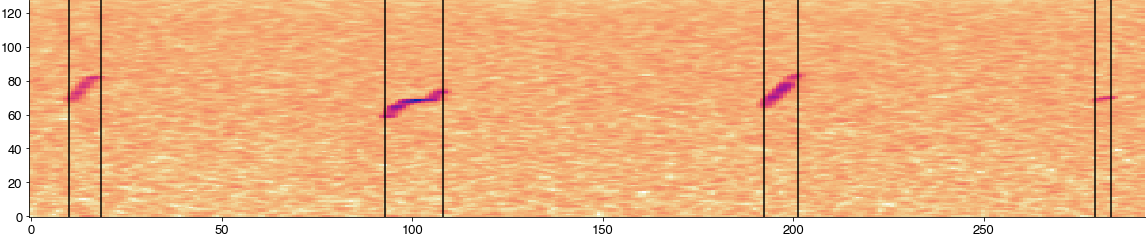

In [4]:
plt.figure(figsize=(20, 4))
plt.imshow(np.log2(specgram[:, int(syllable_onsets[1]/hop_length)-10:int(syllable_offsets[4]/hop_length)+10]), cmap='cet_CET_L17')
for onset, offset in zip(syllable_onsets[1:5], syllable_offsets[1:5]):
    plt.axvline((onset-syllable_onsets[1])/hop_length + 10, c='k')
    plt.axvline((offset-syllable_onsets[1])/hop_length + 10, c='k')

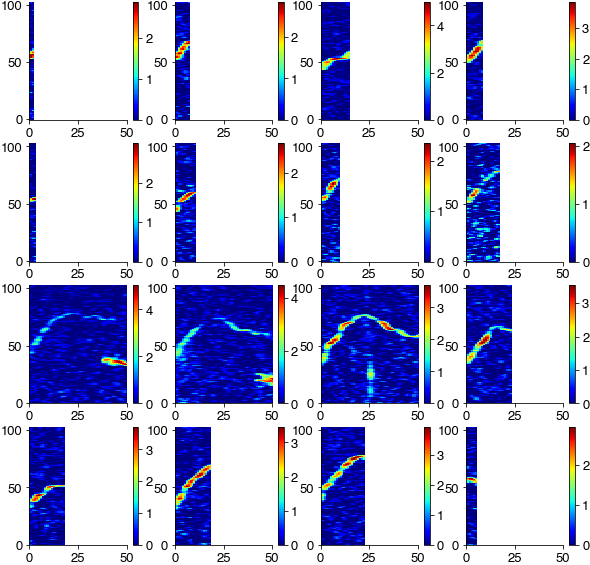

In [5]:
specs = [] 

plt.figure(figsize=(10, 10))
for cnt, (onset, offset) in enumerate(zip(syllable_onsets, syllable_offsets)):
    spec = np.log2(specgram[:, int(onset/hop_length):int(offset/hop_length)]/ sm[:,np.newaxis])
    spec = spec[15:-10, :]
    spec[spec<0] = 0
    specs.append(spec)
    try:
        plt.subplot(4,4,cnt+1)
        plt.imshow(spec, cmap='jet')
        plt.xlim(0, 50)
        plt.colorbar()
    except:
        pass

46


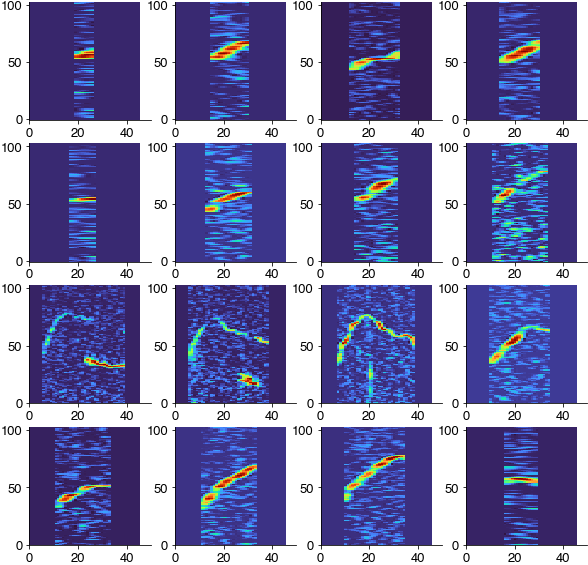

In [6]:
spec_rs = [deepss_unsupervised.spec_utils.log_resize_spec(spec, scaling_factor=8) for spec in specs]

max_len = np.max([spec.shape[1] for spec in spec_rs])
print(max_len)
spec_rs = [deepss_unsupervised.spec_utils.pad_spec(spec, pad_length=max_len) for spec in spec_rs]
plt.figure(figsize=(10, 10))
for cnt, spc in enumerate(spec_rs[:16]):
    plt.subplot(4,4,cnt+1)
    plt.imshow(spc, cmap='turbo')
    plt.xlim(0, 50)


In [7]:
offset = 20
spec_rs_c = [deepss_unsupervised.spec_utils.center_spec(spec, halfwidth=offset) for spec in spec_rs]
spec_rs_c = np.array(spec_rs_c)

In [8]:
spec_flat = [spec.ravel() for spec in spec_rs_c]
spec_flat = np.array(spec_flat)

In [9]:
out = umap.UMAP(min_dist=0.5).fit_transform(spec_flat)

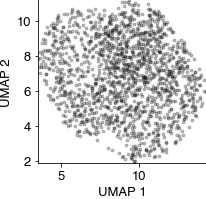

In [10]:
plt.figure(figsize=(3, 3))
plt.scatter(out[:,0], out[:,1], c='k', alpha=0.25, s=8)
plt.axis('tight')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [11]:
# partition umap using kmeans
k_centroid, k_labels = kmeans2(out, k=40)

/Users/janc/miniconda/lib/python3.7/site-packages/scipy/cluster/vq.py:579: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "


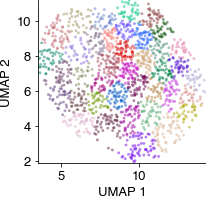

In [12]:
plt.figure(figsize=(3, 3))
plt.scatter(out[:,0], out[:,1], c=k_labels, cmap='cet_glasbey_dark', alpha=0.5, s=8, edgecolor='none')
plt.axis('tight')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

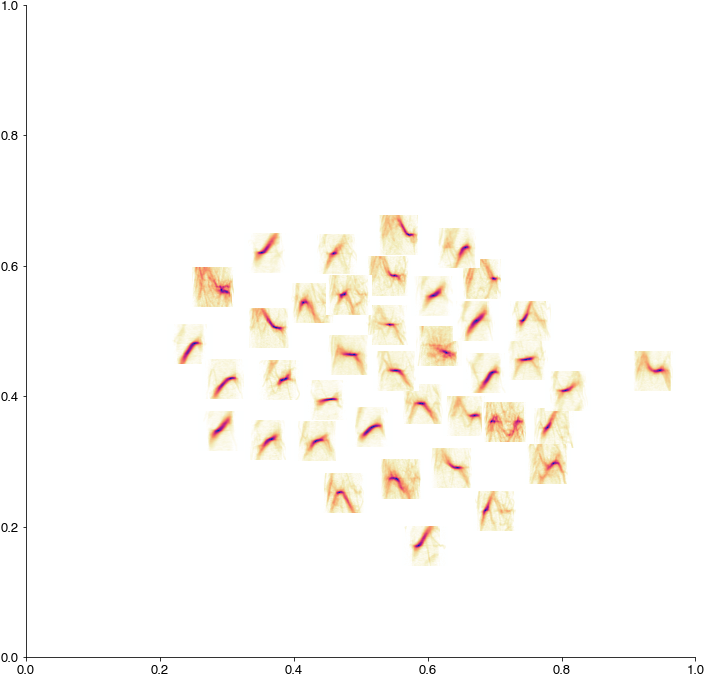

In [13]:
fig = plt.figure(figsize=(12, 12))
ax = plt.axes()
for cnt, (centroid, label) in enumerate(zip(k_centroid, np.unique(k_labels))):
    idx = np.where(k_labels==label)[0]
    X = np.mean(spec_rs_c[idx], axis=0)
    fig.figimage(X=X, xo=centroid[0]*40, yo=centroid[1]*40, cmap='cet_CET_L17')
